# Python для анализа данных

*Алла Тамбовцева, НИУ ВШЭ*

## Web-scraping

Мы уже немного познакомились со структурой html-файлов, теперь попробуем выгрузить информацию из реальной страницы, а точнее, с реального сайта [nplus1.ru](https://nplus1.ru/).

**Наша задача:** выгрузить недавние новости в датафрейм `pandas`, чтобы потом сохранить все в csv-файл.

Сначала сгрузим весь html-код страницы и сохраним его в отдельную переменную. Для этого нам понадобится библиотека `requests`. Импортируем её:

In [1]:
import requests

Сохраним ссылку на главную страницу сайта в переменную `url` для удобства и выгрузим страницу. (Разумеется, это будет работать при подключении к интернету. Если соединение будет отключено, Python выдаст `NewConnectionError`).

In [2]:
url = 'https://nplus1.ru/' # сохраняем
page = requests.get(url) # загружаем страницу по ссылке

Если мы просто посмотрим на объект, мы ничего особенного не увидим:

In [3]:
page  # response 200 - страница загружена

<Response [200]>

Импортируем функцию `BeautifulSoup` из библиотеки `bs4` (от *beautifulsoup4*) и заберём со страницы `page` код html в виде текста. 

In [4]:
from bs4 import BeautifulSoup  # не спрашивайте, почему BeautifulSoup

In [5]:
soup = BeautifulSoup(page.text)

Если выведем `soup` на экран, мы увидим то же самое, что в режиме разработчика или в режиме происмотра исходного кода (`view-source` через *Ctrl+U* в Google Chrome).

In [6]:
soup

<!DOCTYPE html>
<html class="old-town-road no-js bg-fixed" lang="" style="background-image:url(none)">
<head>
<meta charset="utf-8"/>
<meta content="ie=edge" http-equiv="x-ua-compatible"/>
<meta content="width=device-width, initial-scale=1" name="viewport"/>
<meta content="yes" name="apple-mobile-web-app-capable"/>
<meta content="black" name="apple-mobile-web-app-status-bar-style"/>
<meta content="7991d7eb02d759f05b9050e111a7e3eb" name="wmail-verification"/>
<link href="https://nplus1.ru" rel="canonical"/>
<link href="/i/favicon-bw.png" rel="icon"/>
<title>N + 1: научные статьи, новости, открытия</title>
<!-- for Google -->
<meta content="N + 1: научные статьи, новости, открытия" name="description"/>
<meta content="" name="author"/>
<meta content="" name="copyright"/>
<!-- for Facebook -->
<meta content="N + 1: научные статьи, новости, открытия" property="og:title"/>
<meta content="https://nplus1.ru/i/logo.og.png" property="og:image"/>
<meta content="https://nplus1.ru" property="og:url

Для просмотра выглядит не очень удобно.  «Причешем» наш `soup` – воспользуемся методом `.prettify()` в сочетании с функцией `print()`.

In [7]:
print(soup.prettify())

<!DOCTYPE html>
<html class="old-town-road no-js bg-fixed" lang="" style="background-image:url(none)">
 <head>
  <meta charset="utf-8"/>
  <meta content="ie=edge" http-equiv="x-ua-compatible"/>
  <meta content="width=device-width, initial-scale=1" name="viewport"/>
  <meta content="yes" name="apple-mobile-web-app-capable"/>
  <meta content="black" name="apple-mobile-web-app-status-bar-style"/>
  <meta content="7991d7eb02d759f05b9050e111a7e3eb" name="wmail-verification"/>
  <link href="https://nplus1.ru" rel="canonical"/>
  <link href="/i/favicon-bw.png" rel="icon"/>
  <title>
   N + 1: научные статьи, новости, открытия
  </title>
  <!-- for Google -->
  <meta content="N + 1: научные статьи, новости, открытия" name="description"/>
  <meta content="" name="author"/>
  <meta content="" name="copyright"/>
  <!-- for Facebook -->
  <meta content="N + 1: научные статьи, новости, открытия" property="og:title"/>
  <meta content="https://nplus1.ru/i/logo.og.png" property="og:image"/>
  <meta co

В такой выдаче ориентироваться гораздо удобнее (но при желании, то же можно увидеть в браузере, на большом экране).

Чтобы сгрузить все новости с главной страницы сайта, нужно собрать все ссылки на страницы с этими новостями. Ссылки в html-файле всегда заключены в тэг `<a></a>` и имеют атрибут `href`. Посмотрим на кусочки кода, соответствующие всем ссылкам на главной странице сайта:

In [8]:
for link in soup.find_all('a'):
    print(link.get('href'))

#
/
#
#
/rubric/astronomy
/rubric/physics
/rubric/biology
/rubric/robots-drones
/theme/bookshelf
/theme/Courses
/theme/coronavirus-history
/theme/offline
/
#
/rubric/astronomy
/rubric/physics
/rubric/biology
/rubric/robots-drones
#
/theme/bookshelf
/theme/Courses
/theme/coronavirus-history
/theme/offline
https://nplus1.ru/blog/2022/06/14/eye-of-the-albatross
https://nplus1.ru/blog/2022/06/14/eye-of-the-albatross
https://nplus1.ru/blog/2022/06/09/le-theoreme-du-parapluie
https://nplus1.ru/blog/2022/06/07/dig-for-science
https://nplus1.ru/blog/2022/06/07/breathing-lessons
https://nplus1.ru/blog/2022/06/06/marat-spectrometric-analysis
https://nplus1.ru/blog/2022/06/03/tastes-like-moon
https://nplus1.ru/blog/2022/06/03/from-earth-to-neptune-and-beyond
https://nplus1.ru/blog/2022/05/31/jellyfish-age-backwards
https://nplus1.ru/blog/2022/05/27/prehistoric-planet-forests
https://nplus1.ru/blog/2022/06/16/people-and-institutions-of-peters-reform
/news/2022/06/19/drone-in-mars-winter
/news/2022

Ссылок много. Но нам нужны только новости – ссылки, которые начинаются со слова `/news`. Добавим условие: будем выбирать только те ссылки, в которых есть `/news`. Создадим пустой список `urls` и будем добавлять в него только ссылки, которые удовлетворяют этому условию.

In [9]:
urls = []

for link in soup.find_all('a'):
    if '/news' in link.get('href'):
        urls.append(link.get('href'))
urls

['/news/2022/06/19/drone-in-mars-winter',
 '/news/2022/06/18/moon-map',
 '/news/2022/06/18/perovskite-LCP',
 '/news/2022/06/18/hyades-and-sun',
 '/news/2022/06/18/shangdu',
 '/news/2022/06/18/drimolen',
 '/news/2022/06/17/polar-bears',
 '/news/2022/06/17/fullerene-monolayer',
 '/news/2022/06/17/giant-dwarf-crocodiles',
 '/news/2022/06/17/mars-debris',
 '/news/2022/06/17/vision-swimsion',
 '/news/2022/06/17/end-of-cern',
 '/news/2022/06/17/isotopic-g-factor-difference',
 '/news/2022/06/17/sminthopsis-aitkeni',
 '/news/2022/06/17/ancient-teeth',
 '/news/2022/06/17/anglo-saxon-burials',
 '/news/2022/06/17/mutation-rules',
 '/news/2022/06/16/new-omicron-here',
 '/news/2022/06/16/tartarocyon-cazanavei',
 '/news/2022/06/06/are-you-rational',
 '/news/2022/06/15/MicroBooNE-against-MiniBooNe',
 '/news/2022/06/16/MATTG',
 '/news/2022/06/17/isotopic-g-factor-difference',
 '/news/2022/06/17/fullerene-monolayer',
 '/news/2022/06/16/1D-He4',
 '/news/2022/06/14/PN-formation',
 '/news/2022/06/14/hubbl

Ссылки, которые у нас есть в списке `urls`, относительные: они неполные, начало ссылки (название сайта) отсутствует. Давайте превратим их в абсолютные ‒ склеим с ссылкой https://nplus1.ru.

In [10]:
full_urls = []

for u in urls:
    res = 'https://nplus1.ru' + u
    full_urls.append(res) 

full_urls

['https://nplus1.ru/news/2022/06/19/drone-in-mars-winter',
 'https://nplus1.ru/news/2022/06/18/moon-map',
 'https://nplus1.ru/news/2022/06/18/perovskite-LCP',
 'https://nplus1.ru/news/2022/06/18/hyades-and-sun',
 'https://nplus1.ru/news/2022/06/18/shangdu',
 'https://nplus1.ru/news/2022/06/18/drimolen',
 'https://nplus1.ru/news/2022/06/17/polar-bears',
 'https://nplus1.ru/news/2022/06/17/fullerene-monolayer',
 'https://nplus1.ru/news/2022/06/17/giant-dwarf-crocodiles',
 'https://nplus1.ru/news/2022/06/17/mars-debris',
 'https://nplus1.ru/news/2022/06/17/vision-swimsion',
 'https://nplus1.ru/news/2022/06/17/end-of-cern',
 'https://nplus1.ru/news/2022/06/17/isotopic-g-factor-difference',
 'https://nplus1.ru/news/2022/06/17/sminthopsis-aitkeni',
 'https://nplus1.ru/news/2022/06/17/ancient-teeth',
 'https://nplus1.ru/news/2022/06/17/anglo-saxon-burials',
 'https://nplus1.ru/news/2022/06/17/mutation-rules',
 'https://nplus1.ru/news/2022/06/16/new-omicron-here',
 'https://nplus1.ru/news/2022

Теперь наша задача сводится к следующему: изучить одну страницу с новостью, научиться из нее вытаскивать текст и всю необходимую информацию, а потом применить весь набор действий к каждой ссылке из `full_urls` в цикле. Посмотрим на новость с индексом 1, у вас может быть другая, новости обновляются.

In [11]:
url0 = full_urls[1]

page0 = requests.get(url0)
soup0 = BeautifulSoup(page0.text, 'lxml')

В коде каждой страницы с новостью есть часть с мета-информацией: датой, именем автора и проч. Такая информация окружена тэгом `<meta></meta>`. Посмотрим:

In [12]:
soup0.find_all('meta')

[<meta charset="utf-8"/>,
 <meta content="ie=edge" http-equiv="x-ua-compatible"/>,
 <meta content="width=device-width, initial-scale=1" name="viewport"/>,
 <meta content="yes" name="apple-mobile-web-app-capable"/>,
 <meta content="black" name="apple-mobile-web-app-status-bar-style"/>,
 <meta content="7991d7eb02d759f05b9050e111a7e3eb" name="wmail-verification"/>,
 <meta content="2022-06-18" itemprop="datePublished"/>,
 <meta content="Александр Войтюк" name="mediator_author"/>,
 <meta content="Ее масштаб – 1:2 500 000" name="description"/>,
 <meta content="Александр Войтюк" name="author"/>,
 <meta content="" name="copyright"/>,
 <meta content="Китайские астрономы создали детальную геологическую карту Луны" property="og:title"/>,
 <meta content="https://nplus1.ru/images/2022/06/18/5f5c69d3e85be03156cc5ae0ba7a9fce.jpg" property="og:image"/>,
 <meta content="https://nplus1.ru/news/2022/06/18/moon-map" property="og:url"/>,
 <meta content="Ее масштаб – 1:2 500 000" property="og:description"/>

Из этого списка нам нужны части с именем автора, датой, заголовком и кратким описанием. Воспользуемся поиском по атрибуту `name`. Передадим функции `find_all()` в качестве аргумента словарь с названием и значением атрибута: 

In [13]:
soup0.find_all('meta', {'name' : 'author'}) # например, автор

[<meta content="Александр Войтюк" name="author"/>]

Теперь выберем единственный элемент полученного списка (с индексом 0):

In [14]:
soup0.find_all('meta', {'name' : 'author'})[0]

<meta content="Александр Войтюк" name="author"/>

Нам нужно вытащить из этого объекта `content` – имя автора. Посмотрим на атрибуты:

In [15]:
soup0.find_all('meta', {'name' : 'author'})[0].attrs

{'name': 'author', 'content': 'Александр Войтюк'}

Как получить отсюда `content`? Очень просто, ведь это словарь! А доставать из словаря значение по ключу мы умеем.

In [16]:
author = soup0.find_all('meta', {'name' : 'author'})[0].attrs['content']
author

'Александр Войтюк'

Аналогичным образом извлечем дату, заголовок и описание.

In [17]:
date = soup0.find_all('meta', {'itemprop' : 'datePublished'})[0].attrs['content']
title = soup0.find_all('meta', {'property' : 'og:title'})[0].attrs['content']
description = soup0.find_all('meta', {'name' : 'description'})[0].attrs['content']

Осталось вытащить рубрики и сложность текста. Если мы посмотрим на исходный код страницы, мы увидим, что нужная нам информация находится в тэгах `<p></p>`:

In [18]:
soup0.find_all('p')

[<p class="table">
 <a data-rubric="astronomy" href="/rubric/astronomy">Астрономия</a>
 </p>,
 <p class="table">
 <a href="/news/2022/06/18">
 <time content="2022-06-18" data-unix="1655570684" itemprop="datePublished">
 <span>19:44</span>
 <span>18 Июнь 2022</span>
 </time>
 </a>
 </p>,
 <p class="table">
 <a href="/difficult/2.1">
 <span>Сложность</span>
 <span class="difficult-value">2.1</span>
 </a>
 </p>,
 <p class="title"></p>,
 <p class="credits">NSSC / CAS</p>,
 <p>Китайские астрономы представили новую наиболее подробную геологическую карту всей поверхности Луны в масштабе 1:2 500 000, которая создана на основе данных, собранных автоматическими аппаратами разных стран. Предполагается, что карта поможет в дальнейших исследованиях Луны и выборе мест посадки для будущих космических аппаратов, а также пригодится для популяризации науки. Полная версия карты <a href="https://sadr-en.nssdc.ac.cn/detail?dataSetId=972277454573928448&amp;dataSetType=personal" rel="nofollow" target="_blank

Выберем из полученного списка первый элемент и найдем в нем все тэги `<a>`:

In [19]:
soup0.find_all('p')[0].find_all('a')

[<a data-rubric="astronomy" href="/rubric/astronomy">Астрономия</a>]

Получился список из одного элемента. Применим списковые включения – вытащим из каждого элемента (их могло бы быть больше) текст и поместим его в новый список `rubrics`.

In [20]:
soup0.find_all('p')[0].find_all('a')[0].text

'Астрономия'

In [21]:
rubrics = [r.text for r in soup0.find_all('p')[0].find_all('a')]
rubrics

['Астрономия']

Осталась только сложность. Возьмем соответствующий кусок кода:

In [22]:
soup0.find_all('span', {'class' : 'difficult-value'})

[<span class="difficult-value">2.1</span>]

И выберем оттуда текст.

In [23]:
diff = soup0.find_all('span', {'class' : 'difficult-value'})[0].text
diff

'2.1'

Теперь перейдем к тексту самой новости. Как можно заметить, текст сохранен в абзацах `<p></p>`, причем безо всяких атрибутов. Сообщим Python, что нас интересуют куски с пустым атрибутом `class`:

In [24]:
text_list = soup0.find_all('p', {'class' : None})

«Выцепим» все тексты (без тэгов) из полученного списка:

In [25]:
text = [t.text for t in text_list]

Склеим все элементы списка `text` через пробел:

In [26]:
''.join(['1', '2', '3'])

'123'

In [27]:
final_text = ' '.join(text)
final_text

'Китайские астрономы представили новую наиболее подробную геологическую карту всей поверхности Луны в масштабе 1:2 500 000, которая создана на основе данных, собранных автоматическими аппаратами разных стран. Предполагается, что карта поможет в дальнейших исследованиях Луны и выборе мест посадки для будущих космических аппаратов, а также пригодится для популяризации науки. Полная версия карты доступна на сайте Национального центра космических наук Китайской академии наук. С 1990-х годов исследование Луны вступило в новую бурную фазу, в ходе которой к естественному спутнику Земли были запущены около 20 космических аппаратов разных стран, в том числе КНР, Индии и Японии. Благодаря этому ученые получили огромные объемы данных о морфологии и составе поверхности Луны и ее внутренней структуре, что позволяет существенно продвинуться в понимании формирования и эволюции Луны. Структурировать информацию помогают периодически обновляемые геологические карты Луны. Они содержат информацию о геолог

Все здорово, только мешают отступы-переходы на новую строку `\n`. Заменим их на пробелы с помощью метода `.replace`:

In [28]:
final_text = final_text.replace('\n', ' ')

Не прошло и двух пар, как мы разобрались со всем :) Теперь осталось совсем чуть-чуть. Написать готовую функцию для всех проделанных нами действий и применить ее в цикле для всех ссылок в списке `full_urls`. Напишем! Аргументом функции будет ссылка на новость, а возвращать она будет текст новости и всю необходимую информацию (дата, автор, сложность и проч.). Скопируем все строки кода выше.

In [29]:
def GetNews(url0):
    """
    Returns a tuple with url0, date, author, description, title, final_text, rubrics, diff.
    Parameters:
    
    url0 is a link to the news (string)
    """
    page0 = requests.get(url0)
    soup0 = BeautifulSoup(page0.text, 'lxml')
    author = soup0.find_all('meta', {'name' : 'author'})[0].attrs['content']
    date = soup0.find_all('meta', {'itemprop' : 'datePublished'})[0].attrs['content']
    title = soup0.find_all('meta', {'property' : 'og:title'})[0].attrs['content']
    description = soup0.find_all('meta', {'name' : 'description'})[0].attrs['content']
    rubrics = [r.text for r in soup0.find_all('p')[0].find_all('a')]
    diff = soup0.find_all('span', {'class' : 'difficult-value'})[0].text
    text_list = soup0.find_all('p', {'class' : None})
    text = [t.text for t in text_list]
    final_text = ' '.join(text)
    final_text = final_text.replace('\n', ' ')
    
    return url0, date, author, description, title, final_text, rubrics, diff

Уфф. Осталось применить ее в цикле. Но давайте не будем спешить: импортируем функцию `sleep` для задержки, чтобы на каждой итерации цикла, прежде чем перейти к следующей новости, Python ждал несколько секунд. Во-первых, это нужно, чтобы сайт «не понял», чтобы мы его грабим, да еще автоматически. Во-вторых, с небольшой задержкой всегда есть гарантия, что страница прогрузится (сейчас это пока не очень важно, но особенно актуально будет, когда будем обсуждать встраивание в браузер с Selenium). Приступим.

In [30]:
from time import sleep

In [36]:
news = [] # это будет список из кортежей, в которых будут храниться данные по каждой новости

for link in full_urls:
    res = GetNews(link)
    news.append(res)
    sleep(3) # задержка в 3 секунды

ConnectionError: HTTPSConnectionPool(host='nplus1.ru', port=443): Max retries exceeded with url: /news/2022/06/14/PN-formation (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fbd87c588e0>: Failed to establish a new connection: [Errno 60] Operation timed out'))

Так теперь выглядит первый элемент списка:

In [37]:
len(news)

25

In [38]:
news[0]

('https://nplus1.ru/news/2022/06/19/drone-in-mars-winter',
 '2022-06-19',
 'Александр Войтюк',
 'Он стал 29 по счету',
 '«Индженьюити» совершил первый полет в условиях марсианской зимы',
 'Марсианский вертолет «Индженьюити» совершил свой 29 полет, который стал первым в зимнем сезоне на Марсе. Дрон пролетел за 66,6 секунды 179 метров, доказав, что способен полноценно работать в условиях низких температур, сообщается в твиттере NASA. В настоящее время в северном полушарии Марса, где работает дрон\xa0«Индженьюити», наступила зима, что серьезно осложнило работу аппарата, разработанного для марсианского лета. После первого крупного сбоя в мае 2022 года из-за влияния низких температур дрону поменяли суточный цикл работы, по которому\xa0вертолет должен отключаться\xa0на ночь, а утром прогреваться, заряжать батарею и перезагружать свой компьютер. Однако это в начале июня привело к выходу из строя инклинометра, функции которого на себя должен был взять инерциальный измерительный модуль. 11 июня

Импортируем `pandas` и создадим датафрейм из списка кортежей: 

In [39]:
import pandas as pd

In [40]:
df = pd.DataFrame(news)

In [41]:
df.head(2)

,0,1,2,3,4,5,6,7
0,https://nplus1.ru/news/2022/06/19/drone-in-mar...,2022-06-19,Александр Войтюк,Он стал 29 по счету,«Индженьюити» совершил первый полет в условиях...,Марсианский вертолет «Индженьюити» совершил св...,[Космонавтика],1.8
1,https://nplus1.ru/news/2022/06/18/moon-map,2022-06-18,Александр Войтюк,Ее масштаб – 1:2 500 000,Китайские астрономы создали детальную геологич...,Китайские астрономы представили новую наиболее...,[Астрономия],2.1


Переименуем столбцы в базе.

In [42]:
df.columns = ['link', 'date', 'author', 'desc', 'title', 'text', 'rubric', 'diffc']

In [43]:
df.head(2)

,link,date,author,desc,title,text,rubric,diffc
0,https://nplus1.ru/news/2022/06/19/drone-in-mar...,2022-06-19,Александр Войтюк,Он стал 29 по счету,«Индженьюити» совершил первый полет в условиях...,Марсианский вертолет «Индженьюити» совершил св...,[Космонавтика],1.8
1,https://nplus1.ru/news/2022/06/18/moon-map,2022-06-18,Александр Войтюк,Ее масштаб – 1:2 500 000,Китайские астрономы создали детальную геологич...,Китайские астрономы представили новую наиболее...,[Астрономия],2.1


In [44]:
df.dtypes

link      object
date      object
author    object
desc      object
title     object
text      object
rubric    object
diffc     object
dtype: object

Теперь внесем изменения: сделаем столбец `diffc` числовым – типа *float*.

In [45]:
df['diffc'] = df['diffc'].apply(float)

In [46]:
df.dtypes

link       object
date       object
author     object
desc       object
title      object
text       object
rubric     object
diffc     float64
dtype: object

Теперь сложность представлена в базе как количественный показатель, и описывать ее можно соответствующим образом:

In [47]:
df.diffc.describe()

count    25.000000
mean      4.164000
std       2.405009
min       1.100000
25%       2.100000
50%       3.900000
75%       6.500000
max       9.400000
Name: diffc, dtype: float64

Теперь столбец со сложностью точно числовой. Можем даже построить для него гистограмму.

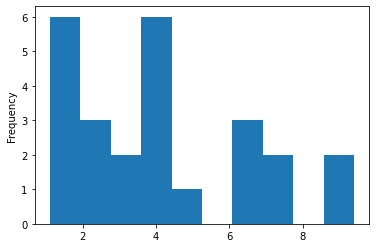

In [48]:
df.diffc.plot.hist();

Объединим рубрики в *text* в одну строку через запятую:

In [49]:
df['rubric'] = [','.join(r) for r in df.rubric]

Давайте почистим текст новостей – уберем оттуда текст, не относящийся к новостям. Найдем лишнее:

In [50]:
df.text[0]

'Марсианский вертолет «Индженьюити» совершил свой 29 полет, который стал первым в зимнем сезоне на Марсе. Дрон пролетел за 66,6 секунды 179 метров, доказав, что способен полноценно работать в условиях низких температур, сообщается в твиттере NASA. В настоящее время в северном полушарии Марса, где работает дрон\xa0«Индженьюити», наступила зима, что серьезно осложнило работу аппарата, разработанного для марсианского лета. После первого крупного сбоя в мае 2022 года из-за влияния низких температур дрону поменяли суточный цикл работы, по которому\xa0вертолет должен отключаться\xa0на ночь, а утром прогреваться, заряжать батарею и перезагружать свой компьютер. Однако это в начале июня привело к выходу из строя инклинометра, функции которого на себя должен был взять инерциальный измерительный модуль. 11 июня 2022 года\xa0«Индженьюити» совершил 29 по счету полет, который стал первым в зимний сезон на Марсе. Полет продлился 66,6 секунды. За это время вертолет преодолел\xa0179 метров со скорость

Лишний текст находится после фразы 'Нашли опечатку?'. Так давайте будем разбивать строки по этой фразе с помощью метода `.split()` и брать все, что до нее (элемент с индексом 0).

In [51]:
df['clean_text'] = [t.split('Нашли опечатку?')[0] for t in df.text]

Осталось только заменить непонятные символы `\xa0` на пробелы:

In [52]:
df['clean_text'] = [t.replace("\xa0", " ") for t in df.clean_text]

In [53]:
df.clean_text[0]

'Марсианский вертолет «Индженьюити» совершил свой 29 полет, который стал первым в зимнем сезоне на Марсе. Дрон пролетел за 66,6 секунды 179 метров, доказав, что способен полноценно работать в условиях низких температур, сообщается в твиттере NASA. В настоящее время в северном полушарии Марса, где работает дрон «Индженьюити», наступила зима, что серьезно осложнило работу аппарата, разработанного для марсианского лета. После первого крупного сбоя в мае 2022 года из-за влияния низких температур дрону поменяли суточный цикл работы, по которому вертолет должен отключаться на ночь, а утром прогреваться, заряжать батарею и перезагружать свой компьютер. Однако это в начале июня привело к выходу из строя инклинометра, функции которого на себя должен был взять инерциальный измерительный модуль. 11 июня 2022 года «Индженьюити» совершил 29 по счету полет, который стал первым в зимний сезон на Марсе. Полет продлился 66,6 секунды. За это время вертолет преодолел 179 метров со скоростью 5,5 метра в с

Всё! Сохраняем датафрейм в файл. Для разнообразия сохраним в Excel:

In [54]:
df.head()

,link,date,author,desc,title,text,rubric,diffc,clean_text
0,https://nplus1.ru/news/2022/06/19/drone-in-mar...,2022-06-19,Александр Войтюк,Он стал 29 по счету,«Индженьюити» совершил первый полет в условиях...,Марсианский вертолет «Индженьюити» совершил св...,Космонавтика,1.8,Марсианский вертолет «Индженьюити» совершил св...
1,https://nplus1.ru/news/2022/06/18/moon-map,2022-06-18,Александр Войтюк,Ее масштаб – 1:2 500 000,Китайские астрономы создали детальную геологич...,Китайские астрономы представили новую наиболее...,Астрономия,2.1,Китайские астрономы представили новую наиболее...
2,https://nplus1.ru/news/2022/06/18/perovskite-LCP,2022-06-18,Наталья Самойлова,"Сначала его добавили для защиты от окисления, ...",Антиоксидант из помидоров продлил жизнь солнеч...,Китайские ученые стабилизировали перовскитные ...,"Материалы,Энергетика",4.3,Китайские ученые стабилизировали перовскитные ...
3,https://nplus1.ru/news/2022/06/18/hyades-and-sun,2022-06-18,Александр Войтюк,Это могло повлиять на орбиты комет,Астрономы уличили скопление Гиады в сближении ...,"Российские астрономы определили, что рассеянно...",Астрономия,4.1,"Российские астрономы определили, что рассеянно..."
4,https://nplus1.ru/news/2022/06/18/shangdu,2022-06-18,Михаил Подрезов,"Палеогенетики исследовали останки, раскопанные...",В некрополе у столицы империи Юань нашли людей...,Палеогенетики секвенировали ДНК девяти индивид...,"Археология,История,Генетика",3.9,Палеогенетики секвенировали ДНК девяти индивид...


In [55]:
df.to_excel('nplus-news.xlsx', index=False)